In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [4]:
# Load both sheets from the same Excel file
file_path = "D:\\Divyakumar\\portfolio\\Git projects\\Retail-Sales-Analysis\\data\\online_retail_II.xlsx"

df1 = pd.read_excel(file_path, sheet_name="Year 2009-2010")
df2 = pd.read_excel(file_path, sheet_name="Year 2010-2011")

# Combine into one dataframe
df = pd.concat([df1, df2], ignore_index=True)

# Quick check
print(df.shape)
df.head()


(1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Remove missing CustomerID
df = df.dropna(subset=['Customer ID'])

# Remove duplicates
df = df.drop_duplicates()

# Remove negative/zero quantities
df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime (already converted)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add TotalPrice column using the 'Price' column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Check cleaned data
print(f"Data shape after cleaning: {df.shape}")
df.head()


Data shape after cleaning: (779495, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


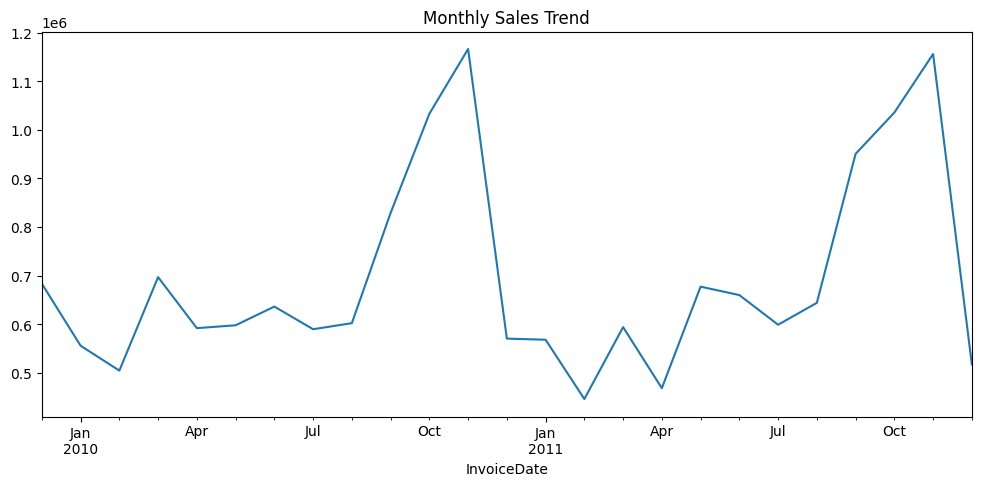

In [6]:
# 1️⃣ Monthly Sales Trend
monthly_sales = df.set_index('InvoiceDate').resample('ME')['TotalPrice'].sum()
monthly_sales.plot(figsize=(12,5), title="Monthly Sales Trend")
plt.show()

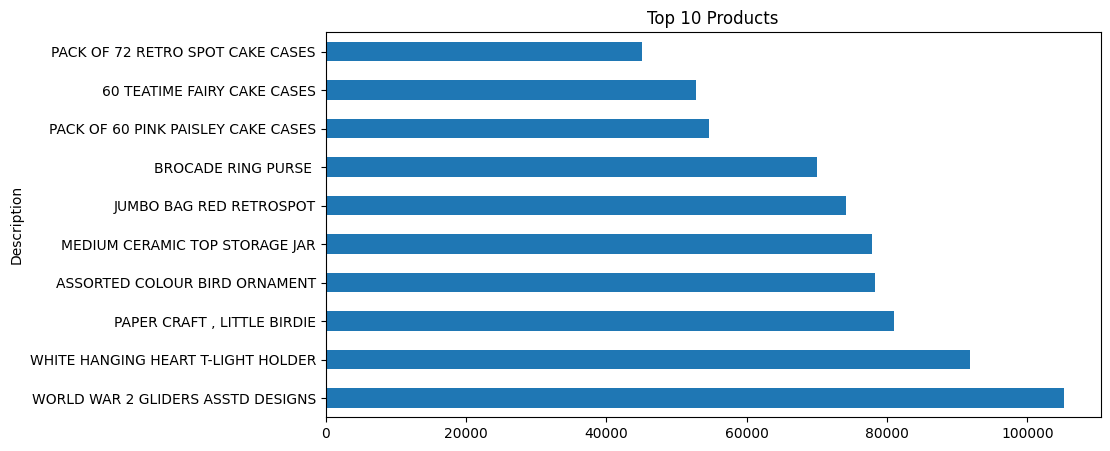

In [6]:
# 2️⃣ Top 10 Products
top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
top_products.plot(kind='barh', figsize=(10,5), title="Top 10 Products")
plt.show()


In [5]:
# 3️⃣ Top 10 Countries by Sales
country_sales = df.groupby('Country')['TotalPrice'].sum().nlargest(10)
fig = px.bar(x=country_sales.index, y=country_sales.values, 
             title="Top 10 Countries by Sales",
             labels={'x': 'Country', 'y': 'Total Sales'})
fig.show()

In [10]:
import datetime as dt

# Reference date = last date in dataset + 1 day
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'count',  # Frequency (using 'Invoice' instead of 'InvoiceNo')
    'TotalPrice': 'sum'    # Monetary
})

rfm.columns = ['Recency','Frequency','Monetary']

# Create RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,326,34,77556.46,2,2,4,224,8
12347.0,2,222,4921.53,4,4,4,444,12
12348.0,75,51,2019.40,3,2,3,323,8
12349.0,19,175,4428.69,4,4,4,444,12
12350.0,310,17,334.40,2,1,1,211,4


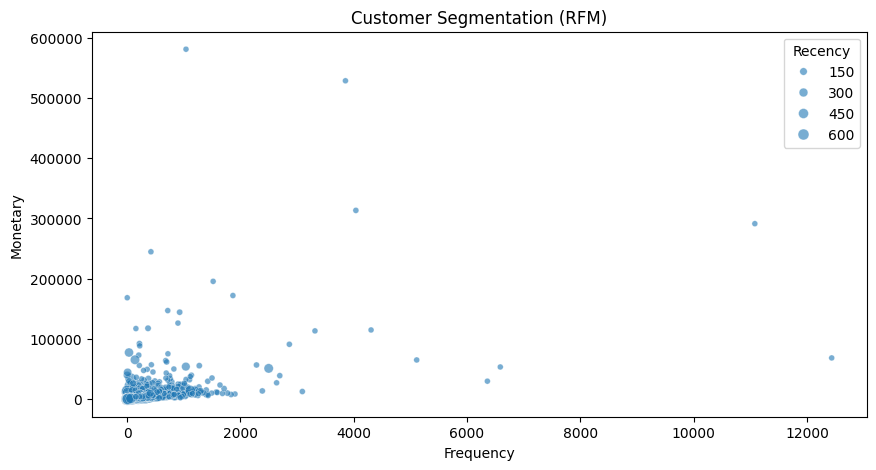

In [11]:
# Scatter: Frequency vs Monetary (bubble size = Recency)
plt.figure(figsize=(10,5))
sns.scatterplot(x='Frequency', y='Monetary', size='Recency', data=rfm, alpha=0.6)
plt.title("Customer Segmentation (RFM)")
plt.show()


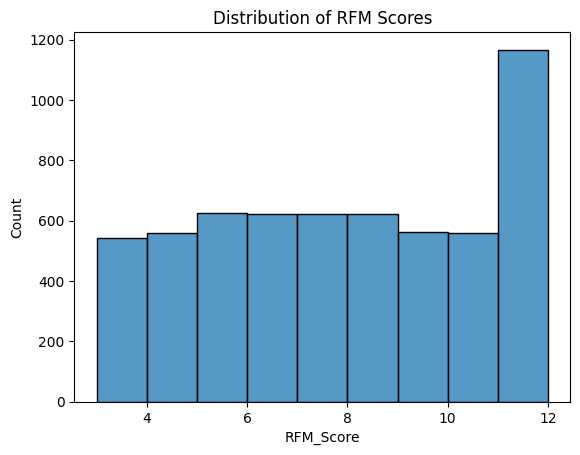

In [15]:
# Distribution of RFM scores
sns.histplot(rfm['RFM_Score'], bins=9)
plt.title("Distribution of RFM Scores")
plt.show()
